# Accident and Casualty Analysis (2022)

In [1]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from Utilities.references import extract_refs, read_refs

In [2]:
warnings.filterwarnings('ignore')

In [3]:
ref_xlsx_path = './data/references/reference.xlsx'
extract_refs(ref_xlsx_path)

ref_path = './data/references/references.json'
references = read_refs(ref_path)

data_path = './data/road_casualty_dataset.csv'
data_df = pd.read_csv(data_path)

In [4]:
data_path = './data/road_casualty_dataset.csv'

# Importing the dataset and removing unnecessary columns
data_df = pd.read_csv(data_path).reset_index()\
    .drop(columns=['index', 'status', 'accident_year',
                   'accident_reference', 'casualty_reference',
                   'casualty_type', 'lsoa_of_casualty',
                   'accident_index', 'casualty_imd_decile'])
data_df

,vehicle_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_home_area_type
0,2,1,2,46,8,3,0,0,0,0,0,1
1,1,1,1,30,6,3,0,0,0,0,0,1
2,1,1,2,58,9,3,0,0,0,0,0,1
3,2,1,2,78,11,3,0,0,0,0,0,2
4,3,1,1,63,9,3,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
61347,1,3,2,56,9,3,10,9,0,0,0,1
61348,1,3,1,14,3,2,5,9,0,0,0,-1
61349,2,1,1,42,7,3,0,0,0,0,0,1
61350,1,1,2,40,7,3,0,0,0,0,0,1


In [5]:
descriptive_stats = data_df.describe()

unique_counts = data_df.nunique()

nan_counts = data_df.apply(lambda x: (x == -1).sum())

print(f"Count of nan values per column:\n{nan_counts}")
print(f"Descriptive Stats of the dataset:\n{descriptive_stats}")
print(f"Count of unique values per column:\n{unique_counts}")

Count of nan values per column:
vehicle_reference                        0
casualty_class                           0
sex_of_casualty                        448
age_of_casualty                       1350
age_band_of_casualty                  1350
casualty_severity                        0
pedestrian_location                      0
pedestrian_movement                      0
car_passenger                          314
bus_or_coach_passenger                  23
pedestrian_road_maintenance_worker     113
casualty_home_area_type               5498
dtype: int64
Descriptive Stats of the dataset:
       vehicle_reference  casualty_class  sex_of_casualty  age_of_casualty  \
count       61352.000000    61352.000000     61352.000000     61352.000000   
mean            1.450368        1.482299         1.368790        36.670312   
std             1.109855        0.735614         0.534536        19.574357   
min             1.000000        1.000000        -1.000000        -1.000000   
25%            

## Managing NAN values

**Note:** We remove nan-valued rows in two columns because there are too many nan values to be filled without compromising the integrity of the dataset.

In [6]:
# Removing nan-valued rows in columns with too many nan values
data_df = data_df[data_df['casualty_home_area_type'] != -1]

**Note:** Each of the remaining columns with nan values are handles using a decision tree

In [7]:
columnlist = [
    'sex_of_casualty',
    'age_of_casualty',
    'age_band_of_casualty',
    'car_passenger',
    'bus_or_coach_passenger',
    'pedestrian_road_maintenance_worker',
]

for target in columnlist:
    # Assuming df is your DataFrame and 'sex_of_casualty' is the column with missing values
    train_df = data_df[data_df[target] != -1]
    predict_df = data_df[data_df[target] == -1]

    # Split into X (features) and y (sex_of_casualty)
    X_train = train_df.drop(target, axis=1)
    y_train = train_df[target]
    X_predict = predict_df.drop(target, axis=1)

    # Create and train the model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    # Predict the missing values
    y_predict = model.predict(X_predict)

    # Fill the missing values in the original DataFrame
    data_df.loc[data_df[target] == -1, target] = y_predict

### Managing Wrong Values

In [8]:
data_df = data_df[(data_df['age_of_casualty'] >= 0) & ((data_df['sex_of_casualty'] == 1) | (data_df['sex_of_casualty'] == 2))]
data_df = data_df[(data_df['car_passenger'] >= 0) & (data_df['car_passenger'] <= 2)]

## Analysis

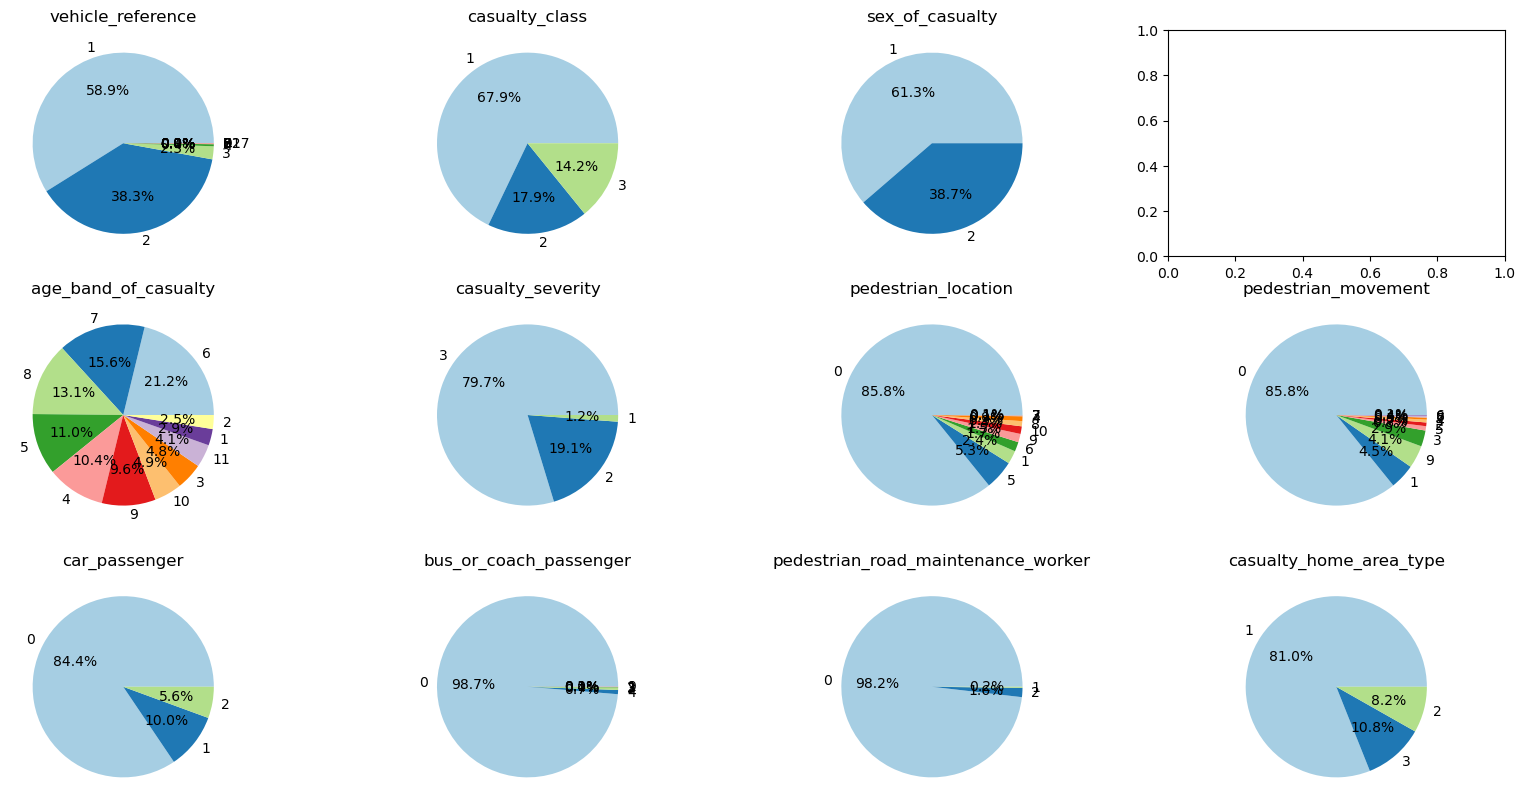

In [10]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
cmap = sns.color_palette("Paired", 100)

for i, col in enumerate(data_df.columns):
    if col == 'age_of_casualty': continue
    ax = axs[i//4, i%4]
    counts = data_df[col].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=cmap)
    ax.set_title(col)

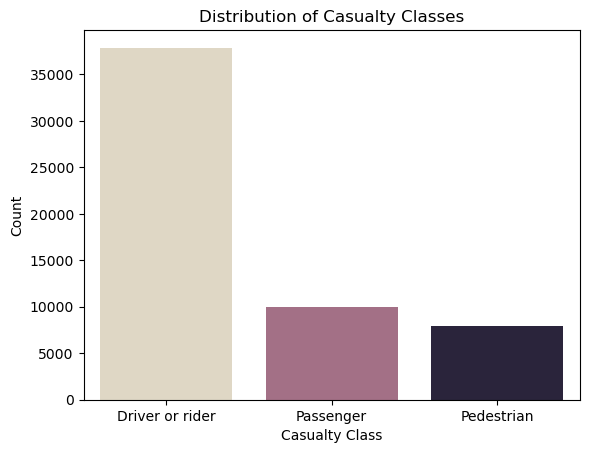

In [11]:
plt.figure()
sns.countplot(data=data_df, x='casualty_class', palette="ch:s=-.2,r=.6", hue='casualty_class', legend=False)
plt.title('Distribution of Casualty Classes')
plt.xlabel('Casualty Class')
plt.ylabel('Count')
plt.xticks(range(len(references['casualty']['class'])), references['casualty']['class'])
plt.show()

In [12]:
casualty_class_counts = data_df['casualty_class'].value_counts(dropna=False)
casualty_class_percentages = casualty_class_counts.apply(lambda x: x/55794)

casualty_class_counts, casualty_class_percentages

(casualty_class
 1    37876
 2    10014
 3     7904
 Name: count, dtype: int64,
 casualty_class
 1    0.678854
 2    0.179482
 3    0.141664
 Name: count, dtype: float64)

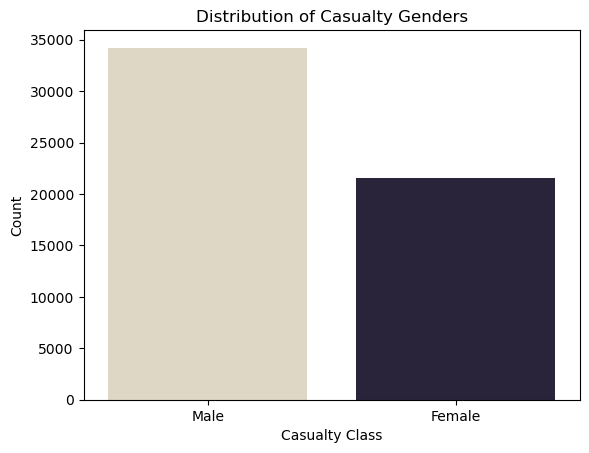

In [13]:
plt.figure()
sns.countplot(data=data_df, x='sex_of_casualty', palette="ch:s=-.2,r=.6", hue='sex_of_casualty', legend=False)
plt.title('Distribution of Casualty Genders')
plt.xlabel('Casualty Class')
plt.ylabel('Count')
plt.xticks(range(len(references['casualty']['gender'][:2])), references['casualty']['gender'][:2])
plt.show()

In [14]:
casualty_class_counts = data_df['sex_of_casualty'].value_counts(dropna=False)
casualty_class_percentages = casualty_class_counts.apply(lambda x: x/55794)

casualty_class_counts, casualty_class_percentages

(sex_of_casualty
 1    34220
 2    21574
 Name: count, dtype: int64,
 sex_of_casualty
 1    0.613328
 2    0.386672
 Name: count, dtype: float64)

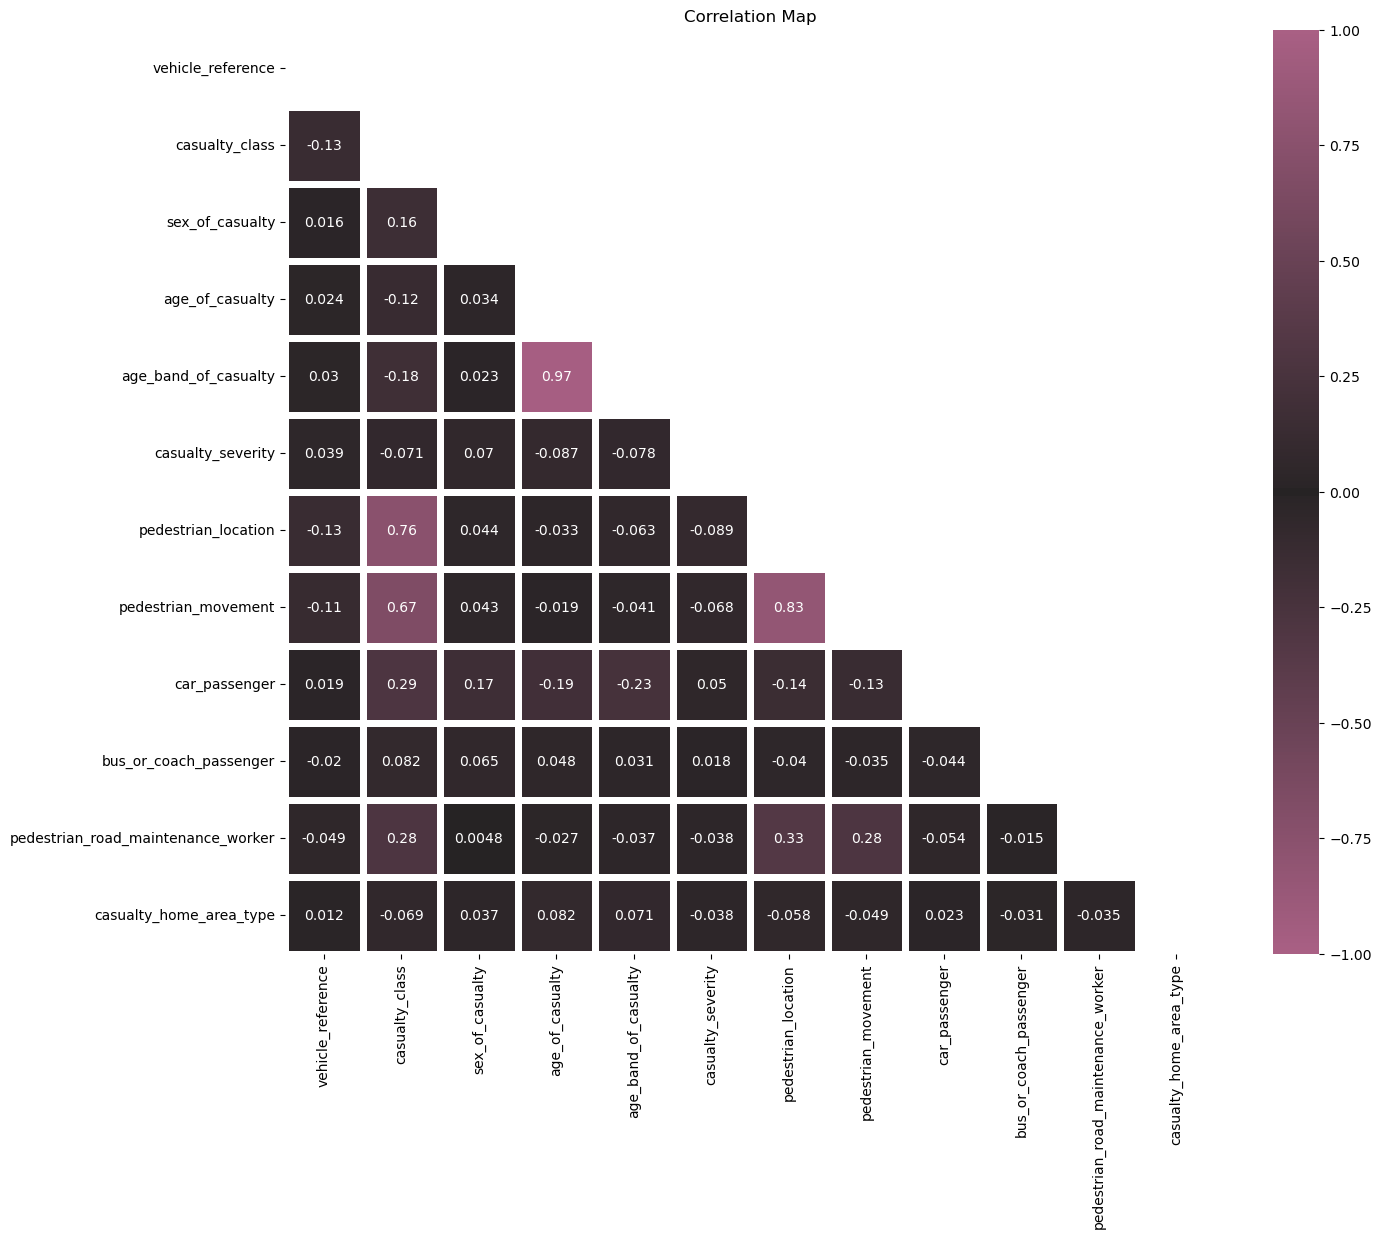

In [15]:
plt.figure(figsize=(15, 12))
corr = data_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(-380, -380, s=40, l=50, center="dark", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,
            vmax=1, vmin=-1, center=0,
            linewidths=5, annot=True)
plt.title('Correlation Map')
plt.show()

In [16]:
x = data_df.drop(['casualty_severity', 'age_of_casualty'], axis=1).astype('category')
y = data_df['casualty_severity']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report_str)

Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       118
           2       0.30      0.04      0.06      2072
           3       0.81      0.98      0.89      8969

    accuracy                           0.80     11159
   macro avg       0.37      0.34      0.32     11159
weighted avg       0.70      0.80      0.72     11159



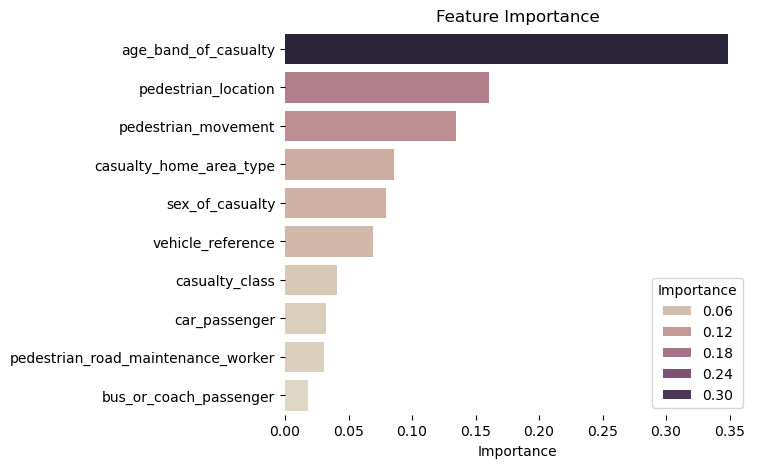

In [18]:
feature_importance = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="ch:s=-.2,r=.6", hue="Importance")
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

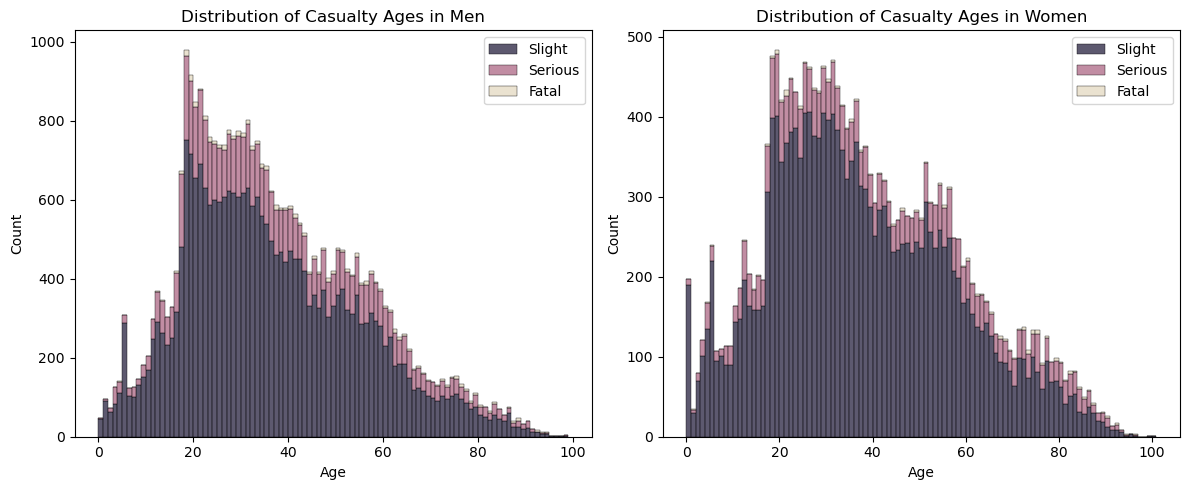

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

male_casualties = data_df[data_df['sex_of_casualty'] == 1]
female_casualties = data_df[data_df['sex_of_casualty'] == 2]

sns.histplot(data=male_casualties, x='age_of_casualty',
             bins=range(male_casualties['age_of_casualty'].min(),
                        male_casualties['age_of_casualty'].max()+1),
             palette="ch:s=-.2,r=.6", hue="casualty_severity", multiple="stack",
             ax=axs[0], legend=False)
axs[0].set_title('Distribution of Casualty Ages in Men')
axs[0].set_xlabel('Age')
axs[0].legend(list(reversed(references['casualty']['severity'])))

sns.histplot(data=female_casualties, x='age_of_casualty',
             bins=range(female_casualties['age_of_casualty'].min(),
                        female_casualties['age_of_casualty'].max()+1),
             palette="ch:s=-.2,r=.6", hue="casualty_severity", multiple="stack",
             ax=axs[1], legend=False)
axs[1].set_title('Distribution of Casualty Ages in Women')
axs[1].set_xlabel('Age')
axs[1].legend(list(reversed(references['casualty']['severity'])))
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [20]:
male_casualties = data_df[data_df['sex_of_casualty'] == 1]
female_casualties = data_df[data_df['sex_of_casualty'] == 2]

total_casualty_by_gender = data_df.groupby(['sex_of_casualty']).size().reset_index(name='counts')

total_severity_by_age = data_df.groupby(['age_band_of_casualty', 'casualty_severity']).size().reset_index(name='counts')
male_severity_by_age = male_casualties.groupby(['age_band_of_casualty', 'casualty_severity']).size().reset_index(name='counts')
female_severity_by_age = female_casualties.groupby(['age_band_of_casualty', 'casualty_severity']).size().reset_index(name='counts')

total_severity_by_age_accumulated = total_severity_by_age.groupby('age_band_of_casualty').sum()
male_severity_by_age_accumulated = male_severity_by_age.groupby('age_band_of_casualty').sum()
female_severity_by_age_accumulated = female_severity_by_age.groupby('age_band_of_casualty').sum()

total_fatal_counts = total_severity_by_age.merge(total_severity_by_age_accumulated, left_on='age_band_of_casualty', right_on='age_band_of_casualty')
total_fatal_counts = total_fatal_counts[total_fatal_counts['casualty_severity_x']==1].drop(columns=['casualty_severity_x', 'casualty_severity_y'])
total_fatal_counts['percentage'] = total_fatal_counts['counts_x'] / total_fatal_counts['counts_y'] * 100

male_fatal_counts = male_severity_by_age.merge(male_severity_by_age_accumulated, left_on='age_band_of_casualty', right_on='age_band_of_casualty')
male_fatal_counts = male_fatal_counts[male_fatal_counts['casualty_severity_x']==1].drop(columns=['casualty_severity_x', 'casualty_severity_y'])
male_fatal_counts['percentage'] = male_fatal_counts['counts_x'] / male_fatal_counts['counts_y'] * 100

female_fatal_counts = female_severity_by_age.merge(female_severity_by_age_accumulated, left_on='age_band_of_casualty', right_on='age_band_of_casualty')
female_fatal_counts = female_fatal_counts[female_fatal_counts['casualty_severity_x']==1].drop(columns=['casualty_severity_x', 'casualty_severity_y'])
female_fatal_counts['percentage'] = female_fatal_counts['counts_x'] / female_fatal_counts['counts_y'] * 100

total_fatal = total_fatal_counts['counts_x'].sum() / total_fatal_counts['counts_y'].sum() * 100
female_fatal = female_fatal_counts['counts_x'].sum() / female_fatal_counts['counts_y'].sum() * 100
male_fatal = male_fatal_counts['counts_x'].sum() / male_fatal_counts['counts_y'].sum() * 100

total_fatal_counts.loc[len(total_fatal_counts)] = [2, 0, 0 , 0]
male_fatal_counts.loc[len(male_fatal_counts)] = [2, 0, 0 , 0]
female_fatal_counts.loc[len(female_fatal_counts)] = [2, 0, 0 , 0]


{'total_fatal': total_fatal, 'male_fatal': male_fatal, 'female_fatal': female_fatal}, total_fatal_counts, male_fatal_counts, female_fatal_counts

({'total_fatal': 1.213101496158512,
  'male_fatal': 1.46834534525554,
  'female_fatal': 0.806028521009205},
     age_band_of_casualty  counts_x  counts_y  percentage
 0                      1         8      1634    0.489596
 5                      3        10      2668    0.374813
 8                      4        68      5781    1.176267
 11                     5        53      6134    0.864037
 14                     6       128     11831    1.081903
 17                     7        74      8690    0.851554
 20                     8        80      7284    1.098298
 23                     9        79      5361    1.473606
 26                    10        68      2741    2.480846
 29                    11        92      2282    4.031551
 10                     2         0         0    0.000000,
     age_band_of_casualty  counts_x  counts_y  percentage
 0                      1         4       793    0.504414
 5                      3         6      1645    0.364742
 8                   

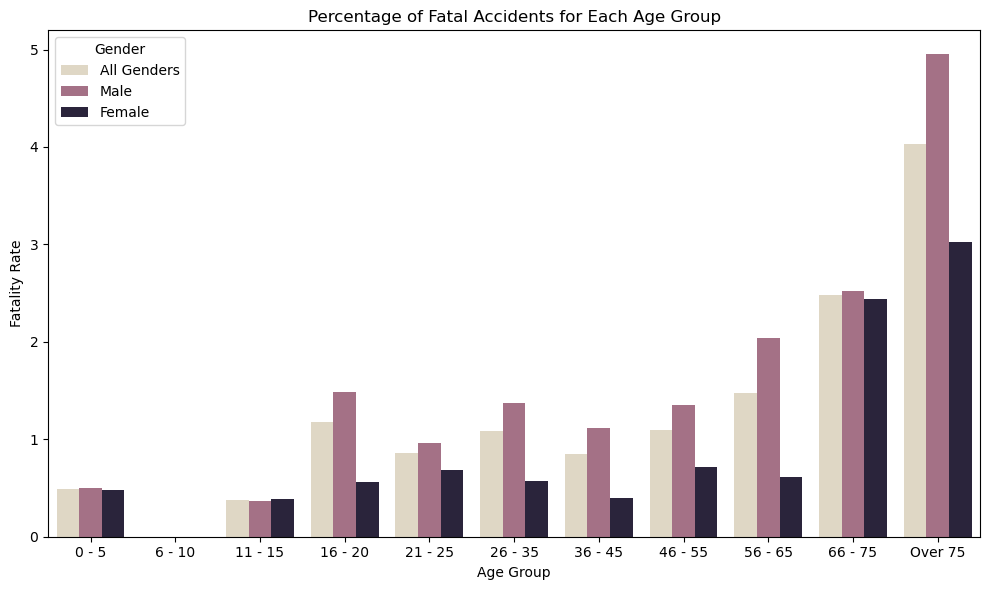

In [21]:
total_fatal_counts['Gender'] = 'All Genders'
male_fatal_counts['Gender'] = 'Male'
female_fatal_counts['Gender'] = 'Female'

# Concatenate the dataframes
all_data = pd.concat([total_fatal_counts, male_fatal_counts, female_fatal_counts])

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='age_band_of_casualty', y='percentage', palette="ch:s=-.2,r=.6", hue='Gender', data=all_data)
plt.title('Percentage of Fatal Accidents for Each Age Group')
plt.xticks(ticks=range(len(references['casualty']['age_band'])-1), labels=references['casualty']['age_band'][:-1])
plt.xlabel('Age Group')
plt.ylabel('Fatality Rate')
plt.tight_layout()

is_pedestrian
0     7904
1    47890
Name: pedestrian_location, dtype: int64


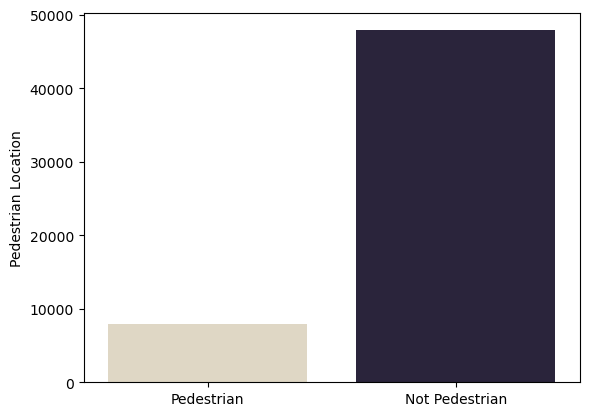

In [22]:
pedestrian_df = data_df
pedestrian_df['is_pedestrian'] = (pedestrian_df['pedestrian_location'] == 0).astype(int)
pedestrian_df = pedestrian_df.groupby('is_pedestrian').count()['pedestrian_location']
print(pedestrian_df)
labels = ['Pedestrian', 'Not Pedestrian']
sns.barplot(data=pedestrian_df, palette="ch:s=-.2,r=.6")
plt.xticks(ticks=range(2), labels=labels)
plt.xlabel('')
plt.ylabel('Pedestrian Location')
plt.show()

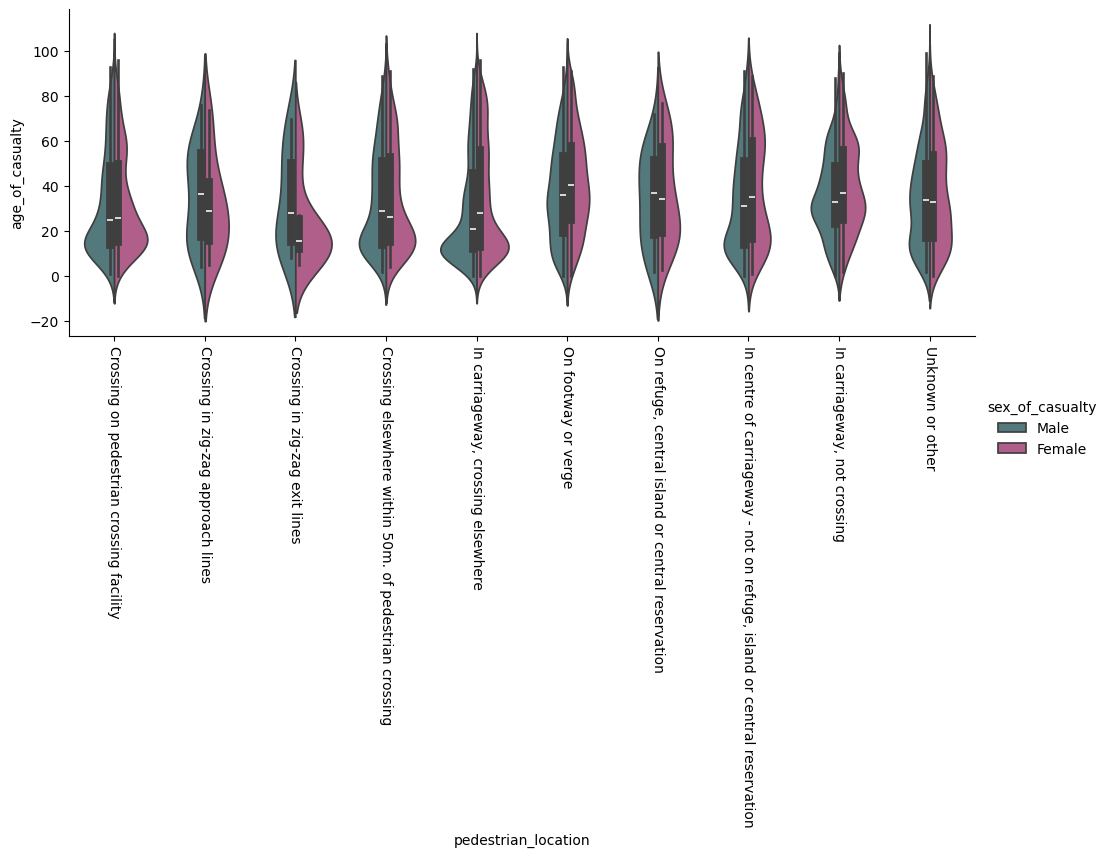

In [23]:
cmap = sns.diverging_palette(200, -380, s=60, l=50, center="dark", as_cmap=True)
catplot = sns.catplot(data=data_df[data_df['pedestrian_location'] != 0], x="pedestrian_location", y="age_of_casualty", palette=cmap, hue="sex_of_casualty", kind="violin", split=True, height=4, aspect=2.5)
catplot.set_xticklabels(references['pedestrian']['location'][1:-1], rotation=-90)
legend = catplot._legend
for t, l in zip(legend.texts, references['casualty']['gender']): t.set_text(l)

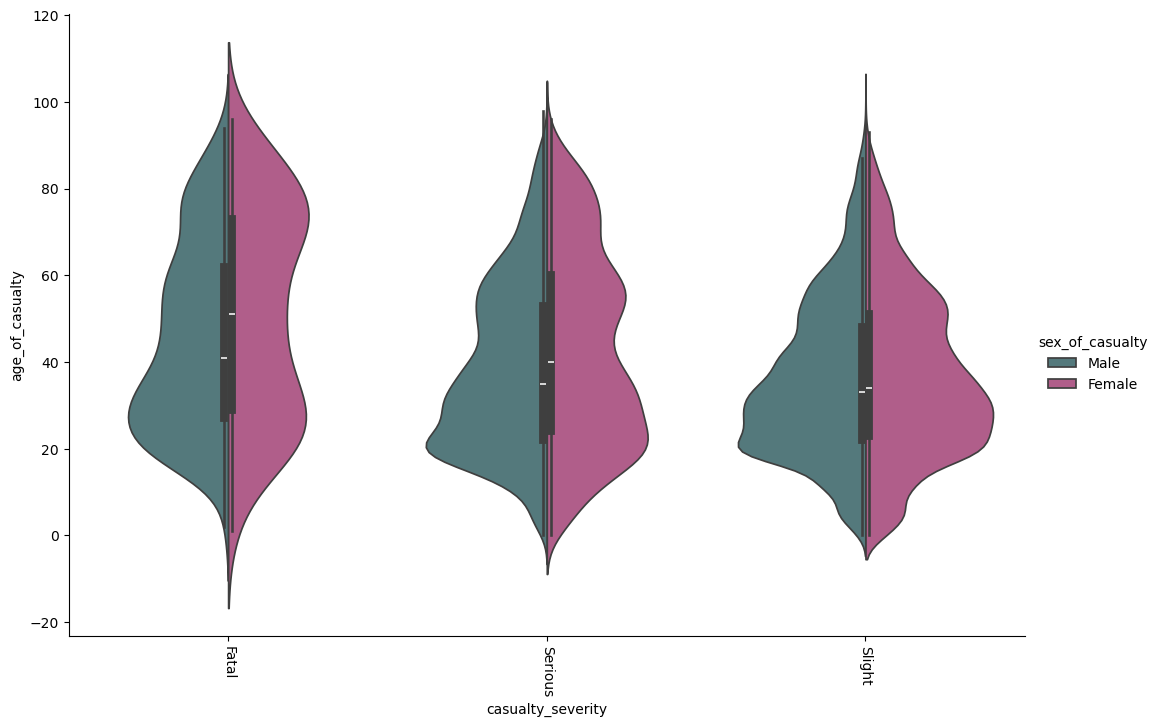

In [24]:
cmap = sns.diverging_palette(200, -380, s=60, l=50, center="dark", as_cmap=True)
catplot = sns.catplot(data=data_df, x="casualty_severity", y="age_of_casualty", palette=cmap, hue="sex_of_casualty", kind="violin", split=True, height=7, aspect=1.5)
catplot.set_xticklabels(references['casualty']['severity'], rotation=-90)
legend = catplot._legend
for t, l in zip(legend.texts, references['casualty']['gender']): t.set_text(l)

In [25]:
data_df[data_df['pedestrian_location'] != 0].groupby('pedestrian_location').count()

,vehicle_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_home_area_type,is_pedestrian
pedestrian_location,,,,,,,,,,,,
1,1317,1317,1317,1317,1317,1317,1317,1317,1317,1317,1317,1317
2,37,37,37,37,37,37,37,37,37,37,37,37
3,30,30,30,30,30,30,30,30,30,30,30,30
4,485,485,485,485,485,485,485,485,485,485,485,485
5,2932,2932,2932,2932,2932,2932,2932,2932,2932,2932,2932,2932
6,948,948,948,948,948,948,948,948,948,948,948,948
7,55,55,55,55,55,55,55,55,55,55,55,55
8,510,510,510,510,510,510,510,510,510,510,510,510
9,833,833,833,833,833,833,833,833,833,833,833,833


Text(0.5, 0, 'Location of Pedestrian')

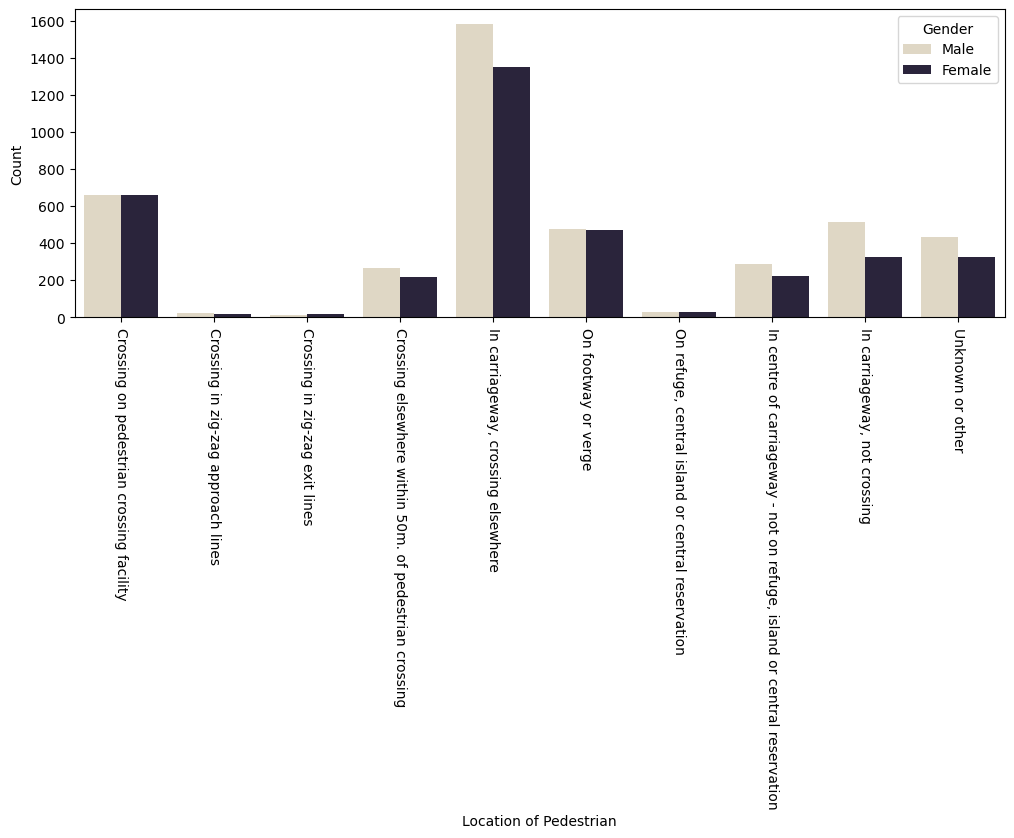

In [26]:
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed
countplot = sns.countplot(data=data_df[data_df['pedestrian_location'] != 0], x="pedestrian_location", hue="sex_of_casualty", palette="ch:s=-.2,r=.6")
countplot.set_xticklabels(references['pedestrian']['location'][1:-1], rotation=-90)
legend = countplot.get_legend()
legend.set_title('Gender')
for t, l in zip(legend.texts, references['casualty']['gender']): t.set_text(l)
plt.ylabel('Count')
plt.xlabel('Location of Pedestrian')

Text(0.5, 0, 'Location of Pedestrian')

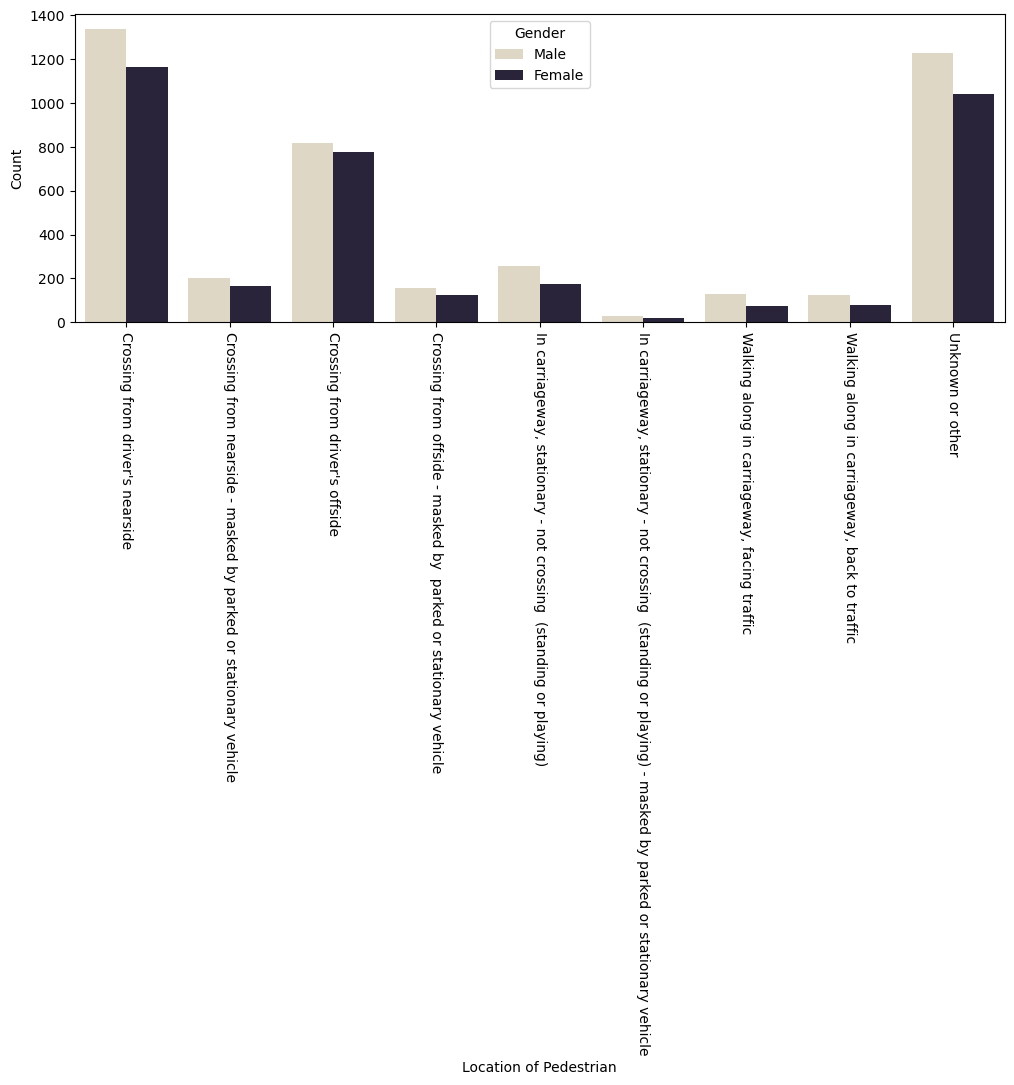

In [27]:
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed
countplot = sns.countplot(data=data_df[data_df['pedestrian_movement'] != 0], x="pedestrian_movement", hue="sex_of_casualty", palette="ch:s=-.2,r=.6")
countplot.set_xticklabels(references['pedestrian']['movement'][1:-1], rotation=-90)
legend = countplot.get_legend()
legend.set_title('Gender')
for t, l in zip(legend.texts, references['casualty']['gender']): t.set_text(l)
plt.ylabel('Count')
plt.xlabel('Location of Pedestrian')

In [28]:
data_df

,vehicle_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_home_area_type,is_pedestrian
0,2,1,2,46,8,3,0,0,0,0,0,1,1
1,1,1,1,30,6,3,0,0,0,0,0,1,1
2,1,1,2,58,9,3,0,0,0,0,0,1,1
3,2,1,2,78,11,3,0,0,0,0,0,2,1
4,3,1,1,63,9,3,0,0,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61346,1,1,1,69,10,2,0,0,0,0,0,1,1
61347,1,3,2,56,9,3,10,9,0,0,0,1,0
61349,2,1,1,42,7,3,0,0,0,0,0,1,1
61350,1,1,2,40,7,3,0,0,0,0,0,1,1
